Importing necessary Libraries.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet.plot import plot_plotly
from statsmodels.tsa.seasonal import seasonal_decompose

Data loading and Preprocessing

In [6]:
sales_df = pd.read_csv('/content/sales_data_sample.csv', encoding='latin1')

sales_df.head()


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [7]:
sales_df['ORDERDATE'] = pd.to_datetime(sales_df['ORDERDATE'])

print(sales_df['PRODUCTLINE'].unique())

['Motorcycles' 'Classic Cars' 'Trucks and Buses' 'Vintage Cars' 'Planes'
 'Ships' 'Trains']


Monthly Sales Analysis for Motercycles

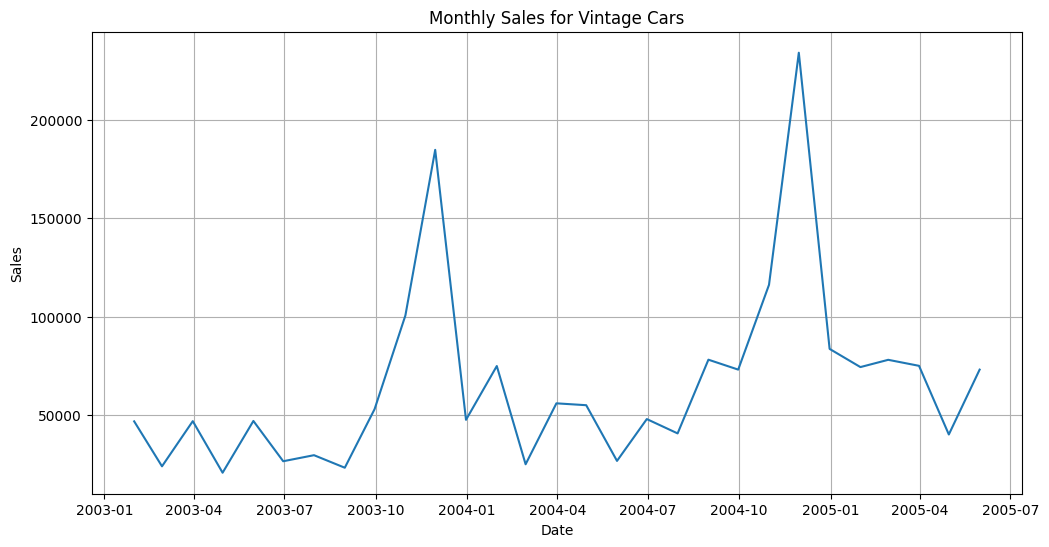

In [50]:
product = 'Vintage Cars'
sales_group = sales_df[sales_df['PRODUCTLINE'] == product].groupby(pd.Grouper(key='ORDERDATE', freq='ME'))['SALES'].sum().reset_index()
sales_group.rename(columns={'ORDERDATE': 'ds', 'SALES': 'y'}, inplace=True)

sales_group.dropna(inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(sales_group['ds'], sales_group['y'])
plt.title(f'Monthly Sales for {product}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)

Time Series Decomposition

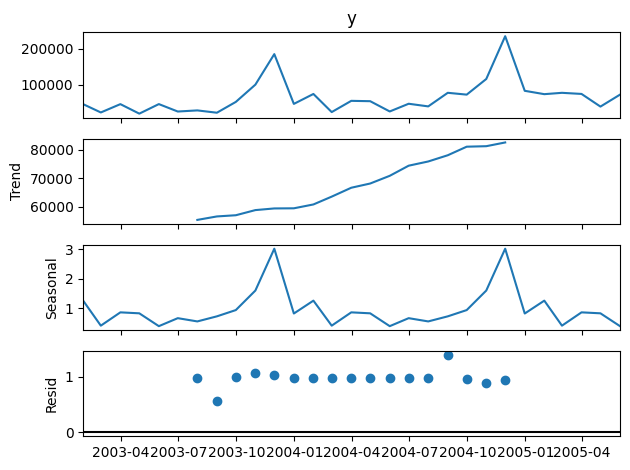

In [52]:

decomposition = seasonal_decompose(sales_group.set_index('ds')['y'], model='multiplicative')
decomposition.plot()
plt.show()

Train model with Additive Seasonality

In [53]:
model = Prophet(seasonality_mode='multiplicative')
model.fit(sales_group)

future = model.make_future_dataframe(periods=6, freq='ME')
forecast = model.predict(future)

plot_plotly(model, forecast)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr5cf1f0k/isu6paws.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr5cf1f0k/ahzeb54b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50186', 'data', 'file=/tmp/tmpr5cf1f0k/isu6paws.json', 'init=/tmp/tmpr5cf1f0k/ahzeb54b.json', 'output', 'file=/tmp/tmpr5cf1f0k/prophet_modeldwx6nbje/prophet_model-20250504111602.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
11:16:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:16:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:

Model Evaluation

In [54]:
predicted = forecast.iloc[:len(sales_group)]

y_true = sales_group['y'].values
y_pred = predicted['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")



MAE: 4905.56
RMSE: 6852.82
MAPE: 12.23%


Actual vs Predicted Sales

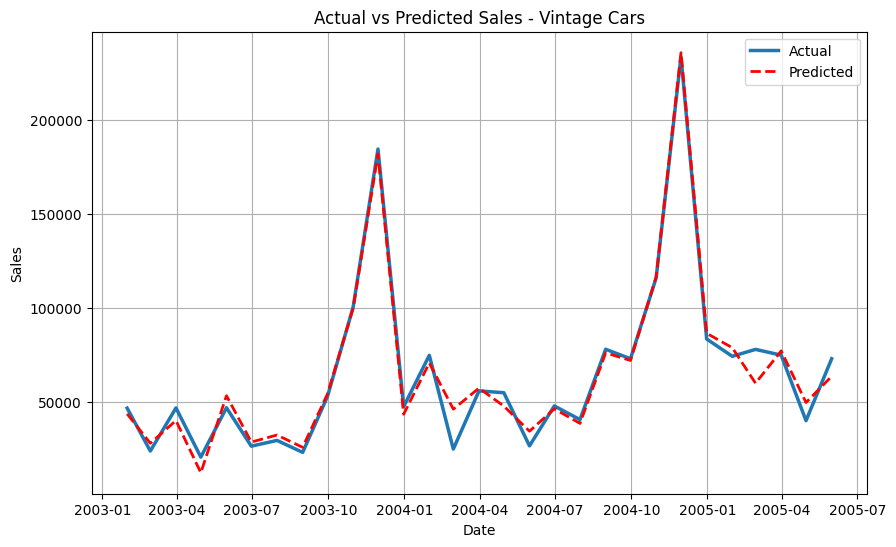

In [60]:
plt.figure(figsize=(10,6))
sns.lineplot(x=predicted['ds'], y=y_true, label='Actual', linewidth=2.5)
sns.lineplot(x=predicted['ds'], y=y_pred, label='Predicted', linestyle='--', linewidth=2, color='r')
plt.title(f'Actual vs Predicted Sales - {product}')
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()

Month with Highest Sales

In [61]:
high_sales = forecast[['ds', 'yhat']].sort_values(by='yhat', ascending=False).iloc[0]

print(f"🔍 Forecast shows {product} sales will peak around: {high_sales['ds'].date()} with approx ${high_sales['yhat']:.2f}")


if len(sales_group) >= 24:
    this_year = sales_group['y'].values[-12:]
    last_year = sales_group['y'].values[-24:-12]
    growth = ((sum(this_year) - sum(last_year)) / sum(last_year)) * 100
    print(f"📈 YoY Growth in Sales: {growth:.2f}%")

🔍 Forecast shows Vintage Cars sales will peak around: 2005-11-30 with approx $304804.14
📈 YoY Growth in Sales: 44.27%
